# Covid Symptom Identification

Project developed by:

- Ana Teresa Cruz (up201806460)
- André Nascimento (up201806461)
- António Bezerra (up201806854)


In [3]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('large_data.csv')

dataset.head()

,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,...,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,ITCHY_NOSE,ITCHY_EYES,ITCHY_MOUTH,ITCHY_INNER_EAR,SNEEZING,PINK_EYE,TYPE
0,0,0,1,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,1,ALLERGY
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,1,ALLERGY
2,0,1,1,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,ALLERGY
3,0,0,0,1,1,0,0,0,0,0,...,0,1,1,0,0,1,0,1,1,ALLERGY
4,0,0,1,0,1,0,0,0,0,0,...,0,1,1,0,1,0,1,1,1,ALLERGY


In [2]:
dataset.describe()

,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,SHORTNESS_OF_BREATH,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,ITCHY_NOSE,ITCHY_EYES,ITCHY_MOUTH,ITCHY_INNER_EAR,SNEEZING,PINK_EYE
count,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000,44453.000000
mean,0.520662,0.519762,0.519897,0.519358,0.496232,0.495850,0.325400,0.324253,0.324523,0.323465,0.323893,0.324455,0.422986,0.423234,0.184285,0.184285,0.184285,0.184285,0.519313,0.184240
std,0.499579,0.499615,0.499610,0.499631,0.499991,0.499988,0.468529,0.468100,0.468201,0.467804,0.467965,0.468176,0.494039,0.494077,0.387720,0.387720,0.387720,0.387720,0.499633,0.387684
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

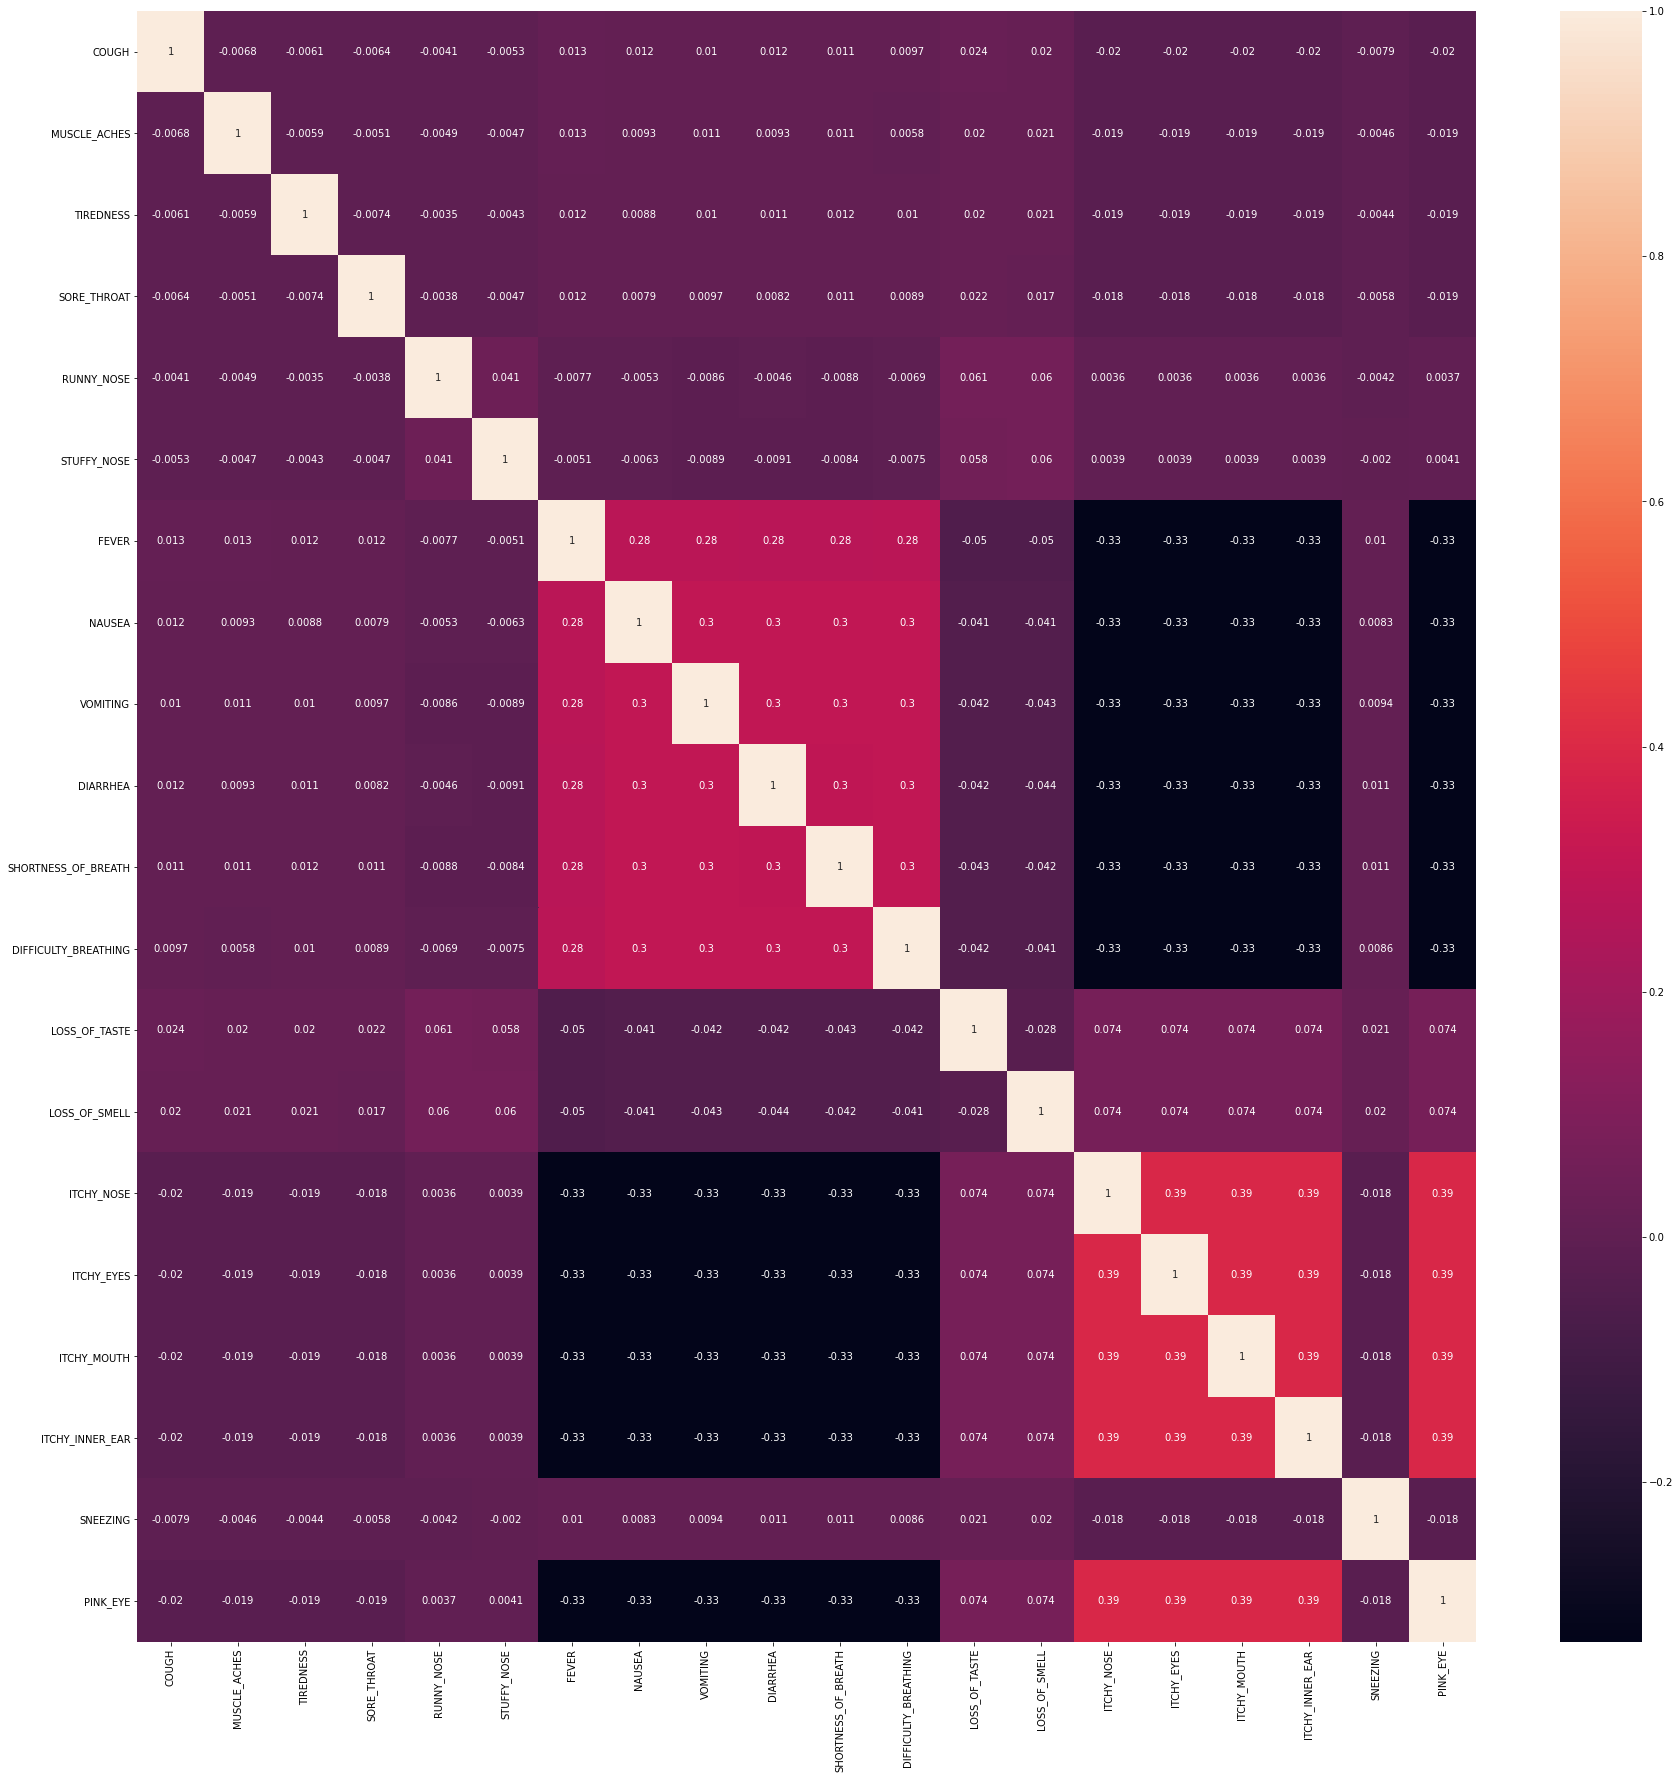

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb

dataset_corr = dataset.corr()
plt.figure(figsize=(30,30))
sb.heatmap(dataset_corr, annot=True)

### All data hist

''

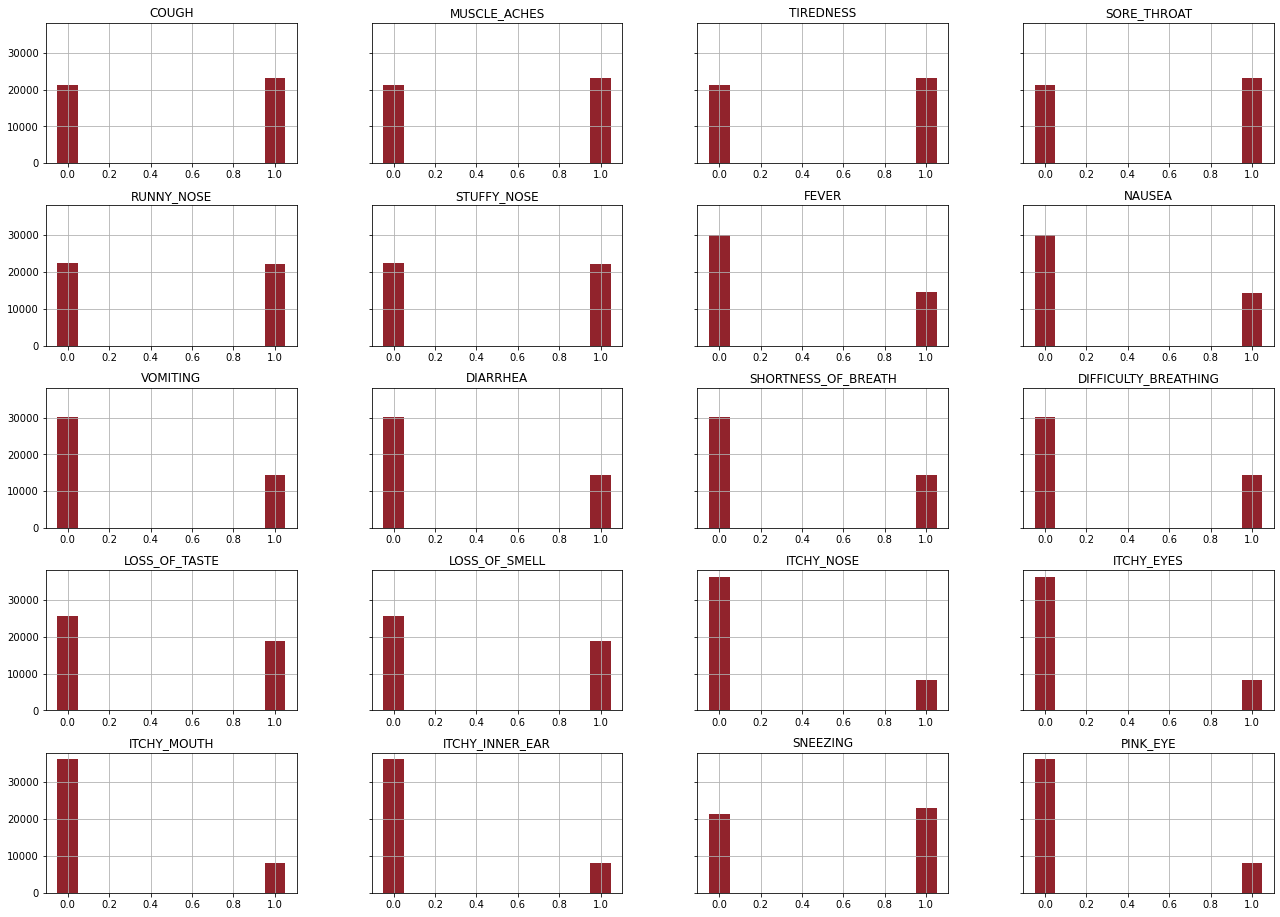

In [33]:
dataset.hist(bins=[-0.05, 0.05, 0.95, 1.05], range=(0,1), figsize=(22, 16), sharey=True, color='#91232C')
;

### Allergy data hist

''

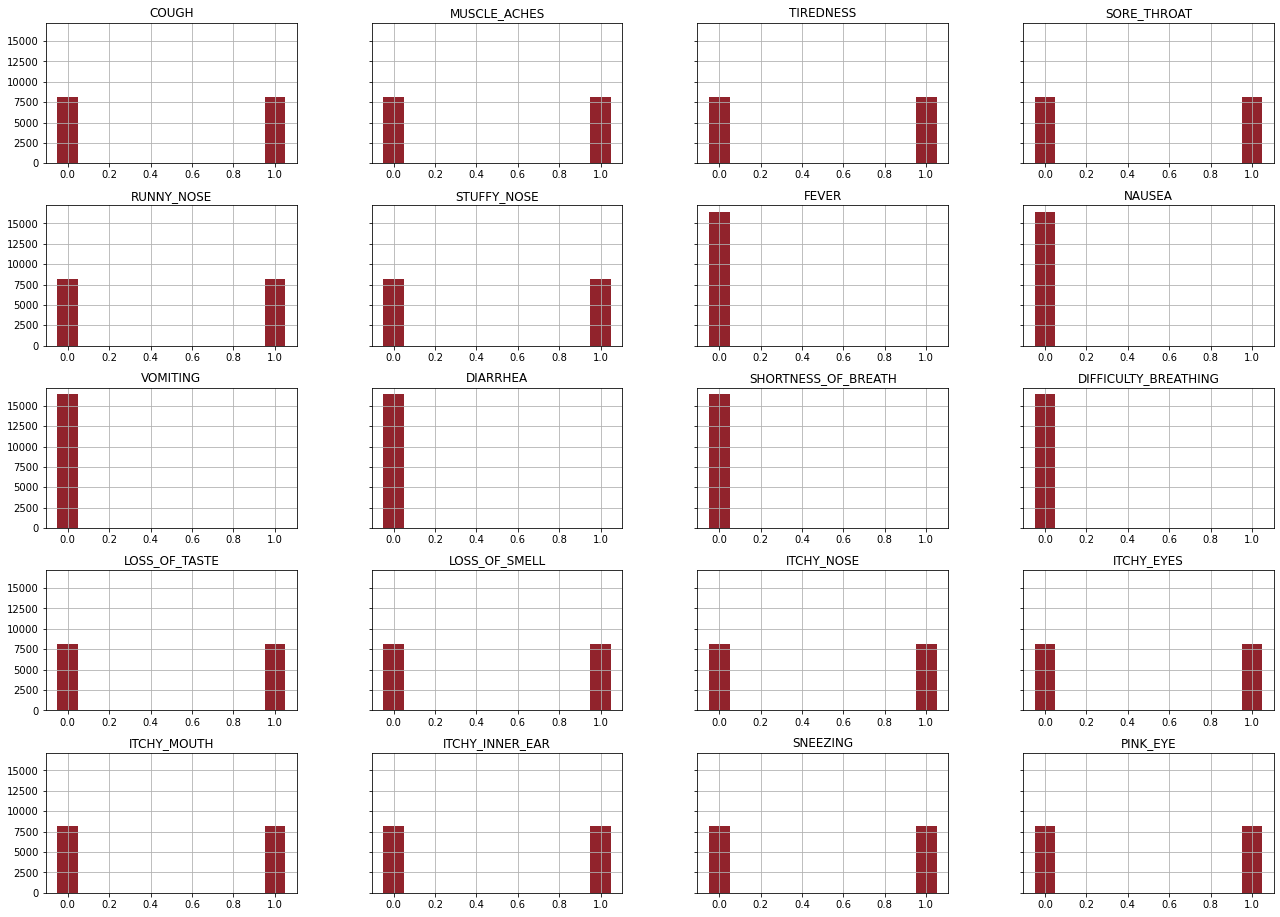

In [28]:
allergy_data = dataset.loc[dataset['TYPE'] == 'ALLERGY']
allergy_data.hist(bins=[-0.05, 0.05, 0.95, 1.05], range=(0,1), figsize=(22,16), sharey=True, color='#91232C')
;

### Cold data hist

''

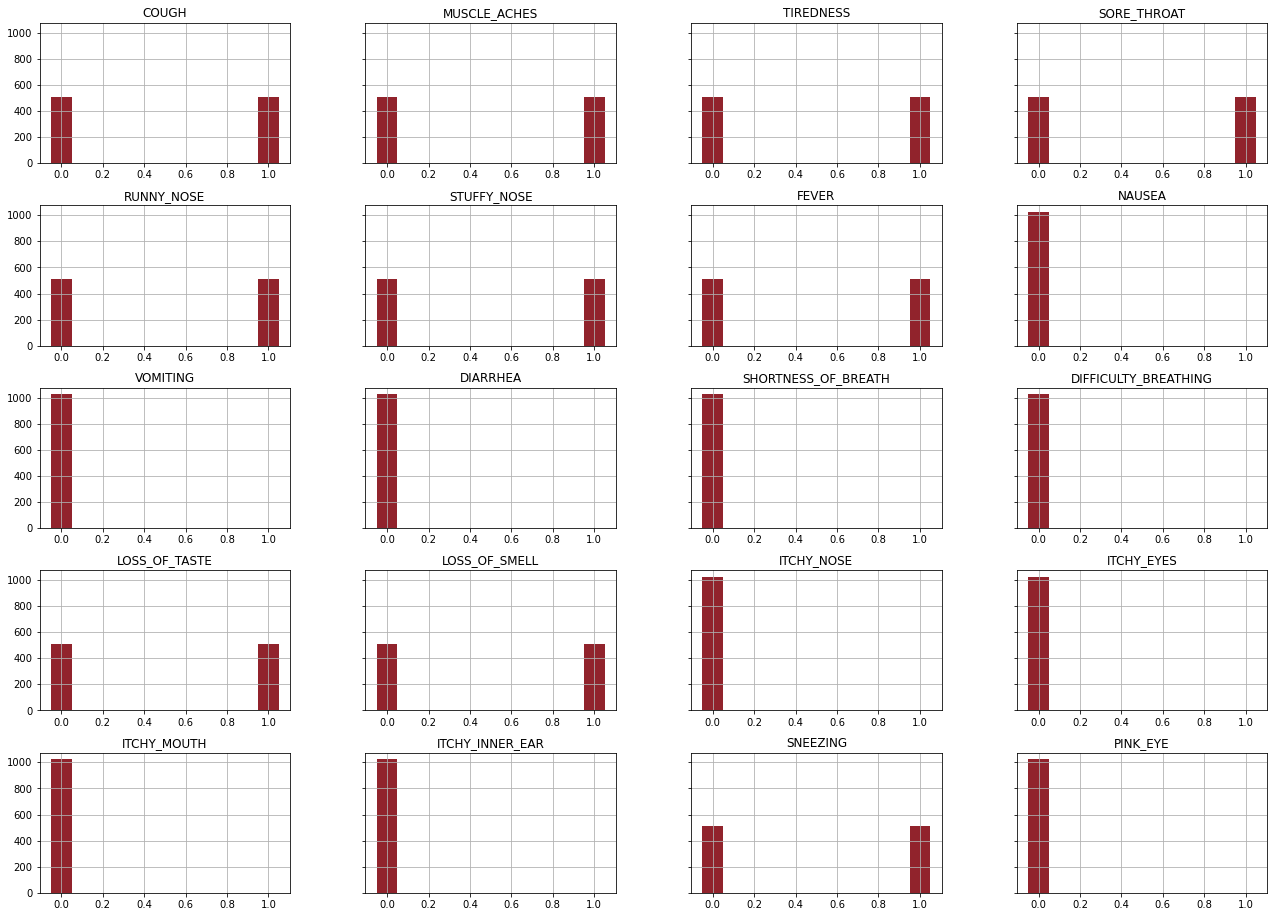

In [29]:
cold_data = dataset.loc[dataset['TYPE'] == 'COLD']
cold_data.hist(bins=[-0.05, 0.05, 0.95, 1.05], range=(0,1), figsize=(22,16), sharey=True, color='#91232C')
;

### Covid data hist

''

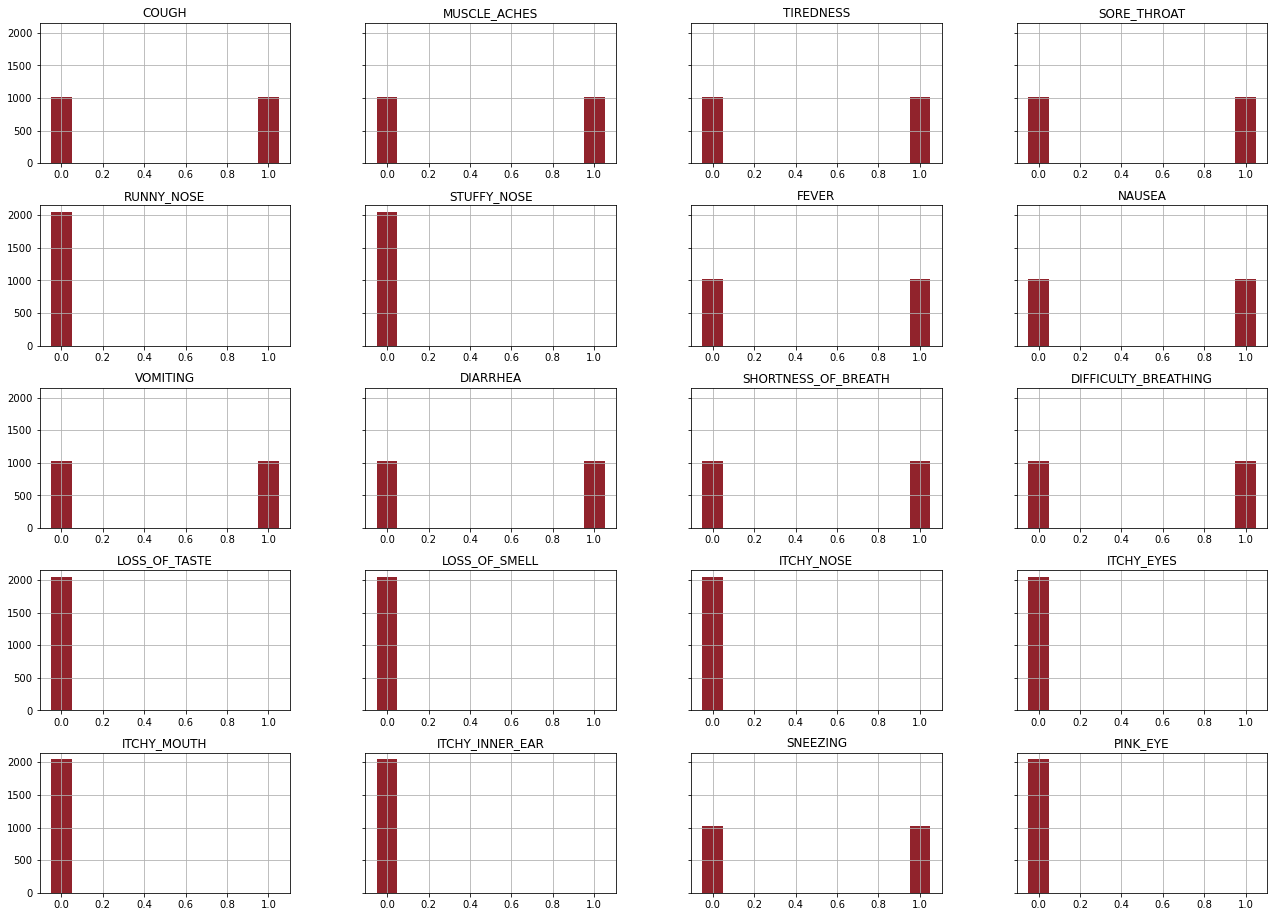

In [30]:
covid_data = dataset.loc[dataset['TYPE'] == 'COVID']
covid_data.hist(bins=[-0.05, 0.05, 0.95, 1.05], range=(0,1), figsize=(22,16), sharey=True, color='#91232C')
;

### Flu data hist

''

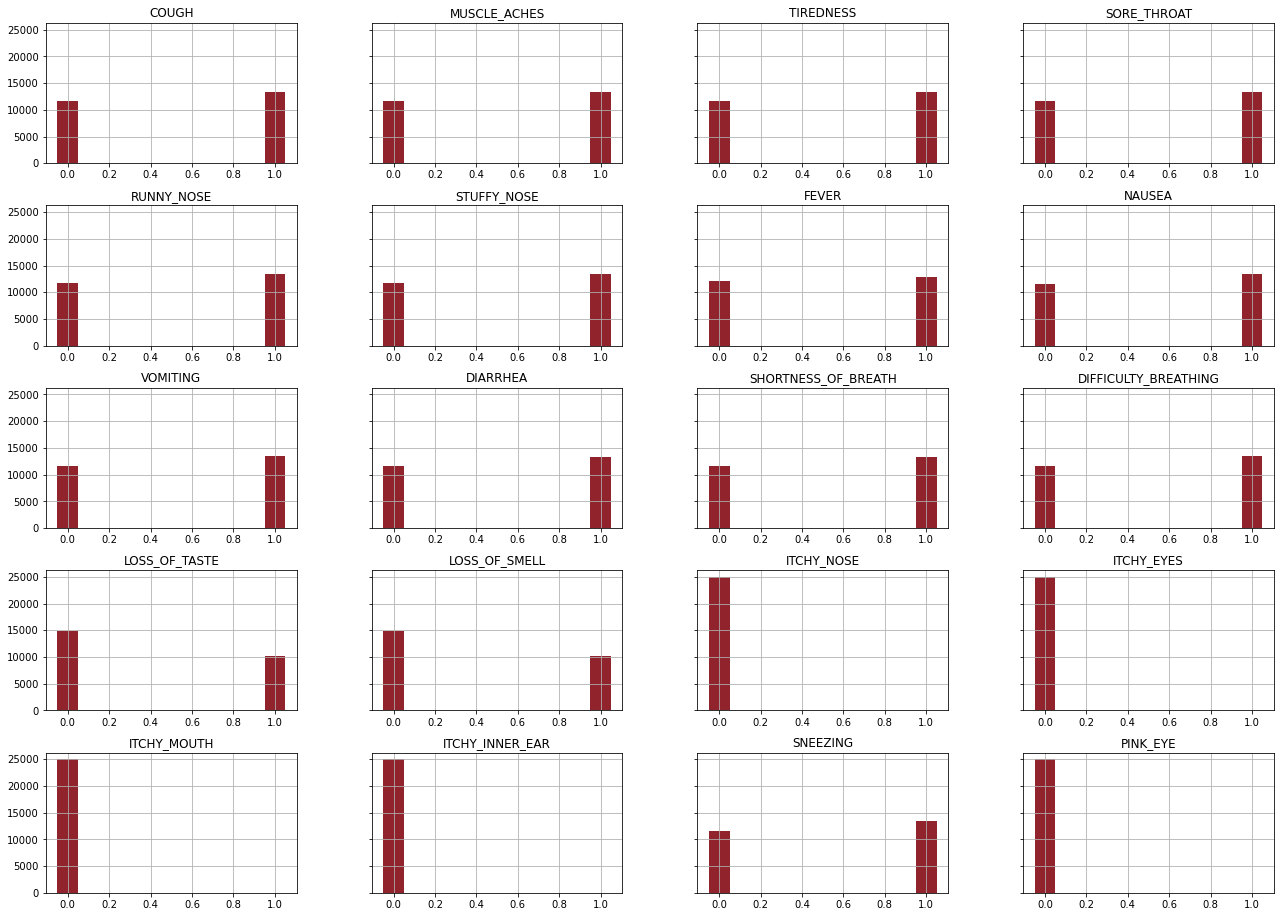

In [31]:
flu_data = dataset.loc[dataset['TYPE'] == 'FLU']
flu_data.hist(bins=[-0.05, 0.05, 0.95, 1.05], range=(0,1), figsize=(22,16), sharey=True, color='#91232C')
;

## Data preprocessing

Since our dataset did not contain null or invalid values or significant outliers, we did not have much preprocessing work to do. The only manipulation we did was split the dataset into input and label sets so that they could be passed to the SciKit classifiers we use.

In [12]:
dataset['TYPE'] = dataset['TYPE'].astype('category')

col_names = list(dataset.columns)
col_names.remove('TYPE')

inputs = dataset[col_names].values
labels = dataset['TYPE'].values

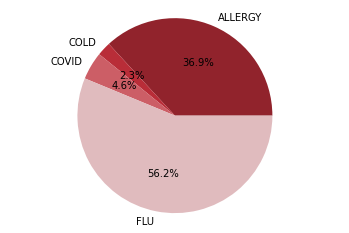

In [71]:
distribution_data = list(Counter(labels).values())

fig1, ax1 = plt.subplots()
colors = ( "#91232C","#B92D38","#CC5E66", "#E0BBBE") 
ax1.pie(distribution_data, colors = colors,labels=['ALLERGY', 'COLD', 'COVID', 'FLU'],autopct='%1.1f%%',)
ax1.axis('equal')  
plt.show()

#### Train and Test split data

We used SciKit's built-in train_test_split function in order to generate train and test datasets. We defined the trainig data as 1/4 of the entire dataset. We use the stratify option in order to maintain the original dataset's class distribution.

In [13]:
from sklearn.model_selection import train_test_split

(train_in,
 test_in,
 train_classes,
 test_classes) = train_test_split(inputs, labels, test_size=0.25, random_state=1, stratify=labels)

### Resampling

Our data analysis stage showed that our working dataset was heavily inbalanced. (inserir percentagens)

Early exploratory analysis of classification methods proved that this was having a negative effect on the accuracy of the classifier, especially for the minority classes. To solve this problem we implemented resampling techniques that would generate a more balanced training set.

We implemented both **undersampling** and **oversampling**. These techniques differ in that undersampling removes samples from majority categories, while oversampling duplicates samples from minority categories. Oversampling is generally preffered, but undersampling generates smaller and therefore less complex datasets.

We used random over and undersampling techniques.


In [14]:
from collections import Counter

print("---Train Set---")
print(Counter(train_classes))
print("\n---Test Set---")
print(Counter(test_classes))

---Train Set---
Counter({'FLU': 18750, 'ALLERGY': 12285, 'COVID': 1536, 'COLD': 768})

---Test Set---
Counter({'FLU': 6250, 'ALLERGY': 4096, 'COVID': 512, 'COLD': 256})


In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()

us_inputs, us_labels = rus.fit_resample(train_in, train_classes)

print(Counter(us_labels))

Counter({'ALLERGY': 768, 'COLD': 768, 'COVID': 768, 'FLU': 768})


In [70]:
from imblearn.over_sampling import SMOTE

ros = SMOTE()

os_inputs, os_labels = ros.fit_resample(train_in, train_classes)

print(Counter(os_labels))

Counter({'ALLERGY': 18750, 'FLU': 18750, 'COLD': 18750, 'COVID': 18750})


## Decision Tree Classifier

#### Original dataset

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

dtc.fit(train_in, train_classes)
dtc_prediction = dtc.predict(test_in)

dtc_classification_report = classification_report(test_classes, dtc_prediction, output_dict=True)

print("--- Original dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, dtc_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, dtc_prediction)}\n")

--- Original dataset ---

Confusion matrix:
[[3978  106    2   10]
 [ 115   75    9   57]
 [  10    6   98  398]
 [  47   68  448 5687]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       0.96      0.97      0.96      4096
        COLD       0.29      0.29      0.29       256
       COVID       0.18      0.19      0.18       512
         FLU       0.92      0.91      0.92      6250

    accuracy                           0.89     11114
   macro avg       0.59      0.59      0.59     11114
weighted avg       0.89      0.89      0.89     11114




#### Undersampled dataset

In [18]:
dtc.fit(us_inputs, us_labels)
dtc_prediction = dtc.predict(test_in)

dtc_us_classification_report = classification_report(test_classes, dtc_prediction, output_dict=True)

print("--- Undersampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, dtc_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, dtc_prediction)}\n")

--- Undersampled dataset ---

Confusion matrix:
[[3968  125    2    1]
 [  14  224   12    6]
 [   0   18  459   35]
 [   3  116  510 5621]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       1.00      0.97      0.98      4096
        COLD       0.46      0.88      0.61       256
       COVID       0.47      0.90      0.61       512
         FLU       0.99      0.90      0.94      6250

    accuracy                           0.92     11114
   macro avg       0.73      0.91      0.79     11114
weighted avg       0.96      0.92      0.93     11114




#### Oversampled dataset

In [19]:
dtc.fit(os_inputs, os_labels)
dtc_prediction = dtc.predict(test_in)

dtc_os_classification_report = classification_report(test_classes, dtc_prediction, output_dict=True)

print("--- Oversampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, dtc_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, dtc_prediction)}\n")

--- Oversampled dataset ---

Confusion matrix:
[[3975  109    2   10]
 [ 104   81   15   56]
 [   0   16  103  393]
 [  17   98  452 5683]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       0.97      0.97      0.97      4096
        COLD       0.27      0.32      0.29       256
       COVID       0.18      0.20      0.19       512
         FLU       0.93      0.91      0.92      6250

    accuracy                           0.89     11114
   macro avg       0.59      0.60      0.59     11114
weighted avg       0.89      0.89      0.89     11114




### Parameter Tunning (GridSearch)

In [20]:
from sklearn.model_selection import GridSearchCV

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [11, 13, 15, 17],
                  'max_features': [14, 15, 16, 17]}

grid_search = GridSearchCV(DecisionTreeClassifier(),
                           param_grid=parameter_grid,
                           cv=10,
                           verbose=4,
                           n_jobs=-1)

#### Original dataset

In [21]:
grid_search.fit(train_in, train_classes)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

Fitting 10 folds for each of 64 candidates, totalling 640 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:   18.4s
Best score: 0.9286421023626057
Best parameters: {'criterion': 'entropy', 'max_depth': 11, 'max_features': 14, 'splitter': 'random'}
Best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=11, max_features=14,
                       splitter='random')
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:   19.8s finished


In [19]:
dtc = grid_search.best_estimator_
dtc_prediction = dtc.predict(test_in)

best_dtc_classification_report = classification_report(test_classes, dtc_prediction, output_dict=True)

print("--- Improved original dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, dtc_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, dtc_prediction)}\n")

--- Improved original dataset ---

Confusion matrix:
[[4044   26    7   19]
 [  82  136   20   18]
 [   0    0  331  181]
 [  53   63  366 5768]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       0.97      0.99      0.98      4096
        COLD       0.60      0.53      0.57       256
       COVID       0.46      0.65      0.54       512
         FLU       0.96      0.92      0.94      6250

    accuracy                           0.92     11114
   macro avg       0.75      0.77      0.76     11114
weighted avg       0.93      0.92      0.93     11114




#### Undersampled dataset

In [20]:
grid_search.fit(us_inputs, us_labels)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best score: 0.9514964677016794
Best parameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 15, 'splitter': 'random'}
Best estimator: DecisionTreeClassifier(max_depth=11, max_features=15, splitter='random')


[Parallel(n_jobs=-1)]: Done 513 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:    1.1s finished


In [21]:
dtc = grid_search.best_estimator_
dtc_prediction = dtc.predict(test_in)

best_us_dtc_classification_report = classification_report(test_classes, dtc_prediction, output_dict=True)

print("--- Improved undersampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, dtc_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, dtc_prediction)}\n")

--- Improved undersampled dataset ---

Confusion matrix:
[[3967  129    0    0]
 [   0  256    0    0]
 [   0   44  468    0]
 [   0  186  470 5594]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       1.00      0.97      0.98      4096
        COLD       0.42      1.00      0.59       256
       COVID       0.50      0.91      0.65       512
         FLU       1.00      0.90      0.94      6250

    accuracy                           0.93     11114
   macro avg       0.73      0.94      0.79     11114
weighted avg       0.96      0.93      0.94     11114




#### Oversampled dataset

In [22]:
grid_search.fit(os_inputs, os_labels)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  1.0min finished


Best score: 0.9582133333333334
Best parameters: {'criterion': 'gini', 'max_depth': 17, 'max_features': 16, 'splitter': 'random'}
Best estimator: DecisionTreeClassifier(max_depth=17, max_features=16, splitter='random')


In [23]:
dtc = grid_search.best_estimator_
dtc_prediction = dtc.predict(test_in)

best_os_dtc_classification_report = classification_report(test_classes, dtc_prediction, output_dict=True)

print("--- Improved oversampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, dtc_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, dtc_prediction)}\n")

--- Improved oversampled dataset ---

Confusion matrix:
[[3967  127    2    0]
 [   0  253    3    0]
 [   0   19  137  356]
 [   0  119  454 5677]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       1.00      0.97      0.98      4096
        COLD       0.49      0.99      0.65       256
       COVID       0.23      0.27      0.25       512
         FLU       0.94      0.91      0.92      6250

    accuracy                           0.90     11114
   macro avg       0.66      0.78      0.70     11114
weighted avg       0.92      0.90      0.91     11114




## K-Nearest Neighbors

#### Original dataset

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(train_in, train_classes)
knn_prediction = knn.predict(test_in)

knn_classification_report = classification_report(test_classes, knn_prediction, output_dict=True)

print("--- Original dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, knn_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, knn_prediction)}\n") 

--- Original dataset ---

Confusion matrix:
[[4022   60    2   12]
 [  94  100    3   59]
 [   8    4  136  364]
 [  45   63  290 5852]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       0.96      0.98      0.97      4096
        COLD       0.44      0.39      0.41       256
       COVID       0.32      0.27      0.29       512
         FLU       0.93      0.94      0.93      6250

    accuracy                           0.91     11114
   macro avg       0.66      0.64      0.65     11114
weighted avg       0.90      0.91      0.91     11114




#### Undersampled dataset

In [23]:
knn.fit(us_inputs, us_labels)
knn_prediction = knn.predict(test_in)

knn_us_classification_report = classification_report(test_classes, knn_prediction, output_dict=True)

print("--- Undersampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, knn_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, knn_prediction)}\n")

--- Undersampled dataset ---

Confusion matrix:
[[3586  508    2    0]
 [   0  250    6    0]
 [   0   20  492    0]
 [   3  770 2081 3396]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       1.00      0.88      0.93      4096
        COLD       0.16      0.98      0.28       256
       COVID       0.19      0.96      0.32       512
         FLU       1.00      0.54      0.70      6250

    accuracy                           0.69     11114
   macro avg       0.59      0.84      0.56     11114
weighted avg       0.94      0.69      0.76     11114




#### Oversampled dataset

In [24]:
knn.fit(os_inputs, os_labels)
knn_prediction = knn.predict(test_in)

knn_os_classification_report = classification_report(test_classes, knn_prediction, output_dict=True)

print("--- Oversampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, knn_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, knn_prediction)}\n")

--- Oversampled dataset ---

Confusion matrix:
[[3868  223    2    3]
 [  86  137   14   19]
 [   3   18  304  187]
 [  12  349  653 5236]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       0.97      0.94      0.96      4096
        COLD       0.19      0.54      0.28       256
       COVID       0.31      0.59      0.41       512
         FLU       0.96      0.84      0.90      6250

    accuracy                           0.86     11114
   macro avg       0.61      0.73      0.64     11114
weighted avg       0.92      0.86      0.88     11114




### Parameter Tunning

In [25]:
parameter_grid = {'n_neighbors': [5, 8, 12, 15],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['ball_tree', 'kd_tree', 'brute']}

grid_search = GridSearchCV(KNeighborsClassifier(),
                           param_grid=parameter_grid,
                           cv=10,
                           verbose=4,
                           n_jobs=-1)

#### Original dataset

In [26]:
grid_search.fit(train_in, train_classes)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  7.9min finished
Best score: 0.9232130891553462
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 15, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(algorithm='ball_tree', n_neighbors=15)


In [27]:
knn = grid_search.best_estimator_
knn_prediction = knn.predict(test_in)

best_knn_classification_report = classification_report(test_classes, knn_prediction, output_dict=True)

print("--- Improved original dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, knn_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, knn_prediction)}\n")

--- Improved original dataset ---

Confusion matrix:
[[4047   30    2   17]
 [ 108   85    2   61]
 [   7    5   60  440]
 [  42   43  168 5997]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       0.96      0.99      0.98      4096
        COLD       0.52      0.33      0.41       256
       COVID       0.26      0.12      0.16       512
         FLU       0.92      0.96      0.94      6250

    accuracy                           0.92     11114
   macro avg       0.67      0.60      0.62     11114
weighted avg       0.90      0.92      0.90     11114




#### Undersampled dataset

In [28]:
grid_search.fit(us_inputs, us_labels)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.1s
Best score: 0.8496277338296883
Best parameters: {'algorithm': 'brute', 'n_neighbors': 12, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(algorithm='brute', n_neighbors=12)
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.9s finished


In [29]:
knn = grid_search.best_estimator_
knn_prediction = knn.predict(test_in)

best_us_knn_classification_report = classification_report(test_classes, knn_prediction, output_dict=True)

print("--- Improved undersampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, knn_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, knn_prediction)}\n")

--- Improved undersampled dataset ---

Confusion matrix:
[[3508  586    2    0]
 [   0  255    1    0]
 [   0   19  493    0]
 [   0 1000 1760 3490]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       1.00      0.86      0.92      4096
        COLD       0.14      1.00      0.24       256
       COVID       0.22      0.96      0.36       512
         FLU       1.00      0.56      0.72      6250

    accuracy                           0.70     11114
   macro avg       0.59      0.84      0.56     11114
weighted avg       0.94      0.70      0.77     11114




#### Oversampled dataset

In [30]:
grid_search = GridSearchCV(KNeighborsClassifier(),
                           param_grid=parameter_grid,
                           cv=5,
                           verbose=4,
                           n_jobs=-1)

grid_search.fit(os_inputs, os_labels)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 23.4min


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [ ]:
knn = grid_search.best_estimator_
knn_prediction = knn.predict(test_in)

best_os_knn_classification_report = classification_report(test_classes, knn_prediction, output_dict=True)

print("--- Improved oversampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, knn_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, knn_prediction)}\n")

## Support-vector machines

#### Original dataset

In [44]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(train_in, train_classes)
svc_prediction = svc.predict(test_in)

svc_classification_report = classification_report(test_classes, svc_prediction, output_dict=True)

print("--- Original dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, svc_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, svc_prediction)}\n")

--- Original dataset ---

Confusion matrix:
[[4096    0    0    0]
 [ 133  116    7    0]
 [  11    3  214  284]
 [  63   52  316 5819]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       0.95      1.00      0.98      4096
        COLD       0.68      0.45      0.54       256
       COVID       0.40      0.42      0.41       512
         FLU       0.95      0.93      0.94      6250

    accuracy                           0.92     11114
   macro avg       0.75      0.70      0.72     11114
weighted avg       0.92      0.92      0.92     11114




#### Undersampled dataset

In [45]:
svc.fit(us_inputs, us_labels)
svc_prediction = svc.predict(test_in)

svc_us_classification_report = classification_report(test_classes, svc_prediction, output_dict=True)

print("--- Undersampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, svc_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, svc_prediction)}\n")

--- Undersampled dataset ---

Confusion matrix:
[[3967  129    0    0]
 [   0  256    0    0]
 [   0   19  493    0]
 [   0  119  484 5647]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       1.00      0.97      0.98      4096
        COLD       0.49      1.00      0.66       256
       COVID       0.50      0.96      0.66       512
         FLU       1.00      0.90      0.95      6250

    accuracy                           0.93     11114
   macro avg       0.75      0.96      0.81     11114
weighted avg       0.97      0.93      0.94     11114




#### Oversampled dataset

In [46]:
svc.fit(os_inputs, os_labels)
svc_prediction = svc.predict(test_in)

svc_os_classification_report = classification_report(test_classes, svc_prediction, output_dict=True)

print("--- Oversampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, svc_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, svc_prediction)}\n")

--- Oversampled dataset ---

Confusion matrix:
[[3967  129    0    0]
 [   0  244   12    0]
 [   0   17  495    0]
 [   0  118  485 5647]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       1.00      0.97      0.98      4096
        COLD       0.48      0.95      0.64       256
       COVID       0.50      0.97      0.66       512
         FLU       1.00      0.90      0.95      6250

    accuracy                           0.93     11114
   macro avg       0.74      0.95      0.81     11114
weighted avg       0.96      0.93      0.94     11114




### Parameter Tunning

In [ ]:
parameter_grid = {'C' : [0.1, 1, 10, 100], 
            'gamma' : ['scale', 'auto'],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid_search = GridSearchCV(SVC(),
                           param_grid=parameter_grid,
                           cv=10,
                           verbose=4,
                           n_jobs=-1)

#### Original dataset

In [ ]:
grid_search.fit(train_in, train_classes)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

In [ ]:
svc = grid_search.best_estimator_
svc_prediction = svc.predict(test_in)

best_svc_classification_report = classification_report(test_classes, svc_prediction, output_dict=True)

print("--- Improved original dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, svc_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, svc_prediction)}\n")

#### Undersampled dataset

In [ ]:
grid_search.fit(us_inputs, us_labels)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

In [ ]:
svc = grid_search.best_estimator_
svc_prediction = svc.predict(test_in)

best_us_svc_classification_report = classification_report(test_classes, svc_prediction, output_dict=True)

print("--- Improved undersampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, svc_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, svc_prediction)}\n")

#### Oversampled dataset

In [ ]:
grid_search.fit(os_inputs, os_labels)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

In [ ]:
svc = grid_search.best_estimator_
svc_prediction = svc.predict(test_in)

best_os_svc_classification_report = classification_report(test_classes, svc_prediction, output_dict=True)

print("--- Improved oversampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, svc_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, svc_prediction)}\n")

## Neural Networks

#### Original dataset

In [48]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

mlp.fit(train_in, train_classes)
mlp_prediction = mlp.predict(test_in)

mlp_classification_report = classification_report(test_classes, mlp_prediction, output_dict=True)

print("--- Original dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, mlp_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, mlp_prediction)}\n")

--- Original dataset ---

Confusion matrix:
[[4050   24    1   21]
 [ 110   78    8   60]
 [   8    3  111  390]
 [  45   34  239 5932]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       0.96      0.99      0.97      4096
        COLD       0.56      0.30      0.39       256
       COVID       0.31      0.22      0.25       512
         FLU       0.93      0.95      0.94      6250

    accuracy                           0.92     11114
   macro avg       0.69      0.61      0.64     11114
weighted avg       0.90      0.92      0.91     11114




#### Undersampled dataset

In [49]:
mlp.fit(us_inputs, us_labels)
mlp_prediction = mlp.predict(test_in)

mlp_us_classification_report = classification_report(test_classes, mlp_prediction, output_dict=True)

print("--- Undersampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, mlp_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, mlp_prediction)}\n")

/home/antonio/.asdf/installs/python/anaconda3-2020.11/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
--- Undersampled dataset ---

Confusion matrix:
[[3967  129    0    0]
 [   0  255    1    0]
 [   0   19  492    1]
 [   0  119  484 5647]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       1.00      0.97      0.98      4096
        COLD       0.49      1.00      0.66       256
       COVID       0.50      0.96      0.66       512
         FLU       1.00      0.90      0.95      6250

    accuracy                           0.93     11114
   macro avg       0.75      0.96      0.81     11114
weighted avg       0.97      0.93      0.94     11114




#### Oversampled dataset

In [50]:
mlp.fit(os_inputs, os_labels)
mlp_prediction = mlp.predict(test_in)

mlp_os_classification_report = classification_report(test_classes, mlp_prediction, output_dict=True)

print("--- Oversampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, mlp_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, mlp_prediction)}\n")


--- Oversampled dataset ---

Confusion matrix:
[[3968  126    2    0]
 [   1  234   18    3]
 [   0   16  496    0]
 [   0  117  486 5647]]

Classification report:
              precision    recall  f1-score   support

     ALLERGY       1.00      0.97      0.98      4096
        COLD       0.47      0.91      0.62       256
       COVID       0.50      0.97      0.66       512
         FLU       1.00      0.90      0.95      6250

    accuracy                           0.93     11114
   macro avg       0.74      0.94      0.80     11114
weighted avg       0.96      0.93      0.94     11114




### Parameter Tunning

In [ ]:
parameter_grid = {'hidden_layer_sizes': [50, 100, 150],
                  'activation' : ['identity', 'logistic', 'tanh', 'relu'],
                  'solver': ['lbfgs', 'sgd', 'adam'],
                  'alpha': [0.0001, 0.001, 0.01]}

grid_search = GridSearchCV(MLPClassifier(), 
                           param_grid=parameter_grid, 
                           cv=10,
                           verbose=4,
                           n_jobs=-1)

#### Original dataset

In [ ]:
grid_search.fit(train_in, train_classes)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

In [ ]:
mlp = grid_search.best_estimator_
mlp_prediction = mlp.predict(test_in)

best_mlp_classification_report = classification_report(test_classes, mlp_prediction, output_dict=True)

print("--- Improved original dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, mlp_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, mlp_prediction)}\n") 

#### Undersampled dataset

In [ ]:
grid_search.fit(us_inputs, us_labels)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

In [ ]:
mlp = grid_search.best_estimator_
mlp_prediction = mlp.predict(test_in)

best_us_mlp_classification_report = classification_report(test_classes, mlp_prediction, output_dict=True)

print("--- Improved undersampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, mlp_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, mlp_prediction)}\n") 

#### Oversampled dataset

In [ ]:
grid_search.fit(os_inputs, os_labels)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

In [ ]:
mlp = grid_search.best_estimator_
mlp_prediction = mlp.predict(test_in)

best_os_mlp_classification_report = classification_report(test_classes, mlp_prediction, output_dict=True)
%store best_os_mlp_classification_report

print("--- Improved oversampled dataset ---\n")
print(f"Confusion matrix:\n{confusion_matrix(test_classes, mlp_prediction)}\n")
print(f"Classification report:\n{classification_report(test_classes, mlp_prediction)}\n") 

## Result Analysis

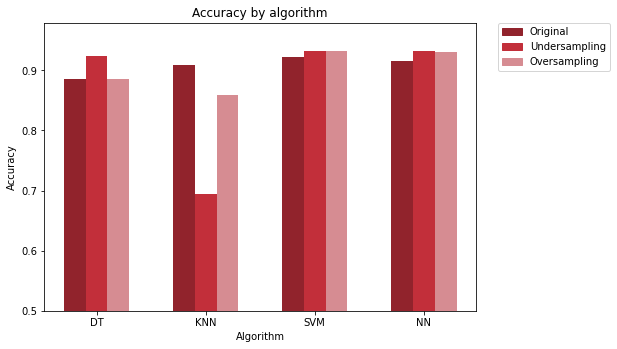

In [60]:
prediction_data = [
    [dtc_classification_report['accuracy'], knn_classification_report['accuracy'], svc_classification_report['accuracy'], mlp_classification_report['accuracy']],
    [dtc_us_classification_report['accuracy'], knn_us_classification_report['accuracy'], svc_us_classification_report['accuracy'], mlp_us_classification_report['accuracy']],
    [dtc_os_classification_report['accuracy'], knn_os_classification_report['accuracy'], svc_os_classification_report['accuracy'], mlp_os_classification_report['accuracy']],
]

X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0, prediction_data[0], color='#91232C', width=0.2)
ax.bar(X + 0.2, prediction_data[1], color='#C22F3A', width=0.2, tick_label=['DT', 'KNN', 'SVM', 'NN'])
ax.bar(X + 0.4, prediction_data[2], color='#D68C92', width=0.2)
ax.set_ylim(ymin=0.5)

original = mpatches.Patch(color='#91232C', label='Original')
undersampled = mpatches.Patch(color='#C22F3A', label='Undersampling')
oversampled = mpatches.Patch(color='#D68C92', label='Oversampling')
plt.legend(handles=[original, undersampled, oversampled], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.title("Accuracy by algorithm")

plt.show()